In [10]:
import sys
sys.path.insert(0,"/home/gridsan/hwpang/Software/RMG-Py/")
sys.path.insert(0,"..")

import string

import numpy as np

import pandas as pd

from joblib import Parallel, delayed
from tqdm import tqdm

from rdmc.mol import RDKitMol
from rdkit.Chem.Descriptors import ExactMolWt, NumRadicalElectrons
from rdkit.Chem.rdMolDescriptors import CalcNumRings, CalcNumHBD, CalcNumHeavyAtoms, CalcNumRotatableBonds
from rdkit.Chem import GetPeriodicTable

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

from tree.parameters import Ts

# Plot HBI distribution

In [11]:
HBI_correction_df = pd.read_csv("../data/hbi.csv")
HBI_correction_df

,radical_smiles,resonance_radical_smiles,resonance_radical_num_rotatable_bonds,radical_H298 (kcal/mol),radical_Sint298 (cal/mol/K),radical_source,radical_level_of_theory,radical_Cp300 (cal/mol/K),radical_Cp400 (cal/mol/K),radical_Cp500 (cal/mol/K),...,closed_shell_thermo_source,HBI_H298 (kcal/mol),HBI_Sint298 (cal/mol/K),HBI_Cp300 (cal/mol/K),HBI_Cp400 (cal/mol/K),HBI_Cp500 (cal/mol/K),HBI_Cp600 (cal/mol/K),HBI_Cp800 (cal/mol/K),HBI_Cp1000 (cal/mol/K),HBI_Cp1500 (cal/mol/K)
0,[O]C(=O)OC(O)(O)O,[O]C(=O)OC(O)(O)O,4,-223.514126,95.999974,dong_pio_liang.py,CBS-QB3,33.926878,38.387673,41.508496,...,GAV,101.203465,-4.589644,2.364565,1.559776,0.412894,-0.172027,-1.041685,-1.683176,-3.705453
1,[O]C(O)(O)OC(=O)O,[O]C(O)(O)OC(=O)O,3,-223.423390,92.781436,dong_pio_liang.py,CBS-QB3,32.531179,37.569659,41.498443,...,GAV,101.294200,-7.808181,0.968866,0.741762,0.402841,0.476043,0.534574,0.412253,-1.394250
2,O=C(O)O[C](O)O,O=C(O)O[C](O)O,3,-187.322869,89.517068,dong_pio_liang.py,CBS-QB3,28.973242,34.553073,38.746721,...,GAV,96.140974,-4.610350,1.758768,2.587490,2.714389,2.346110,1.178471,0.282207,-0.997631
3,CC(=O)OC(OO)C(=O)C(O)O[O],CC(=O)OC(OO)C(=O)C(O)O[O],8,-185.660577,132.633380,dong_pio_liang.py,CBS-QB3,56.569703,66.028226,73.603744,...,GAV,100.658735,-12.393484,3.863088,3.589450,2.161239,1.702481,1.262146,-0.928170,-3.176204
4,O=[C]OC(O)(O)O,O=[C]OC(O)(O)O,5,-180.497563,90.031975,dong_pio_liang.py,CBS-QB3,32.378191,36.844343,39.334179,...,GAV,88.101481,-4.835845,5.443029,5.881647,4.696512,3.708683,1.768296,0.144000,-3.234417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2804,C1=C[CH]C=1,[C]1=CC=C1,0,156.106582,65.385768,dong_pio_liang.py,CBS-QB3,14.653111,18.488757,21.562144,...,GAV,103.873082,3.435468,-0.850889,-1.431243,-1.911856,-2.405821,-3.006968,-3.449835,-4.556360
2805,C=C=C1C=[C]C1,C=C=C1C=[C]C1,0,157.733085,77.587625,dong_pio_liang.py,CBS-QB3,22.675255,28.333884,32.976246,...,GAV,118.466211,25.815240,0.258337,-1.155381,-2.024215,-2.373362,-2.314548,-2.090808,-2.168527
2806,[CH2]C1=CC#CC1,[CH2]C1=CC#CC1,1,163.498344,75.963844,dong_pio_liang.py,CBS-QB3,22.606638,28.495118,33.391100,...,GAV,84.371344,0.823844,-0.802362,-1.521882,-1.227900,-2.500041,-3.127836,-3.711522,-2.960733
2807,[CH2]C1=CC#CC1,C=C1[CH]C#CC1,0,163.498344,75.963844,dong_pio_liang.py,CBS-QB3,22.606638,28.495118,33.391100,...,GAV,78.831344,0.773844,-0.212362,-0.521882,-0.797900,-1.120041,-2.017836,-2.931522,-2.570733


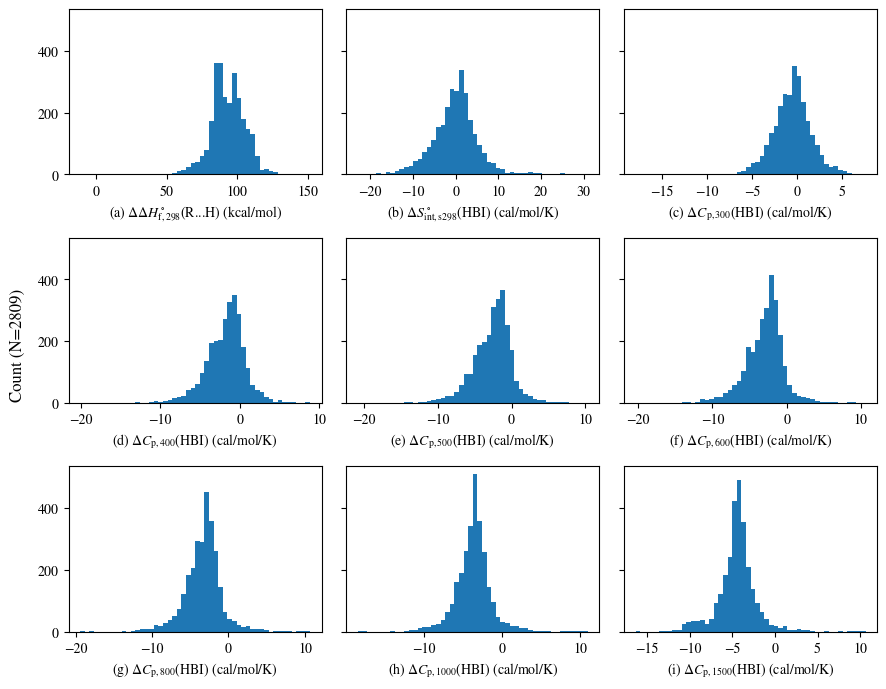

In [12]:
fig, axs = plt.subplots(nrows=3, ncols=3, sharey=True, figsize=(9, 7))
ax = axs.flat[0]
ax.hist(HBI_correction_df["HBI_H298 (kcal/mol)"], bins=50)
ax.set_xlabel("(a) $\Delta \Delta H^\circ_\mathrm{f,298}$(R...H) (kcal/mol)")

ax = axs.flat[1]
ax.hist(HBI_correction_df["HBI_Sint298 (cal/mol/K)"], bins=50)
ax.set_xlabel("(b) $\Delta S^\circ_\mathrm{int,s298}$(HBI) (cal/mol/K)")

for ax, T, alph in zip(axs.flat[2:], Ts, list(string.ascii_lowercase)[2:]):
    ax.hist(HBI_correction_df[f"HBI_Cp{T} (cal/mol/K)"], bins=50)
    ax.set_xlabel(f"({alph}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$(HBI) (cal/mol/K)")

fig.supylabel(f'Count (N={len(HBI_correction_df.index)})')
fig.tight_layout()
fig.savefig("../figures/data_hbi_hist.pdf", bbox_inches="tight")